### Librerias necesarias

In [21]:
import mysql.connector
import pandas as pd
import numpy as np
from datetime import datetime
from mysql.connector import errorcode
import matplotlib.pyplot as plt
import seaborn as sns


### Conexion a MySQL para extraer tabla

In [2]:
try:
    # Intentar conectar a la base de datos
    cnx = mysql.connector.connect(
        user='EquipoG',
        password='E1q2u3i4p5oG',
        database='Equip_G',
        host='212.227.90.6',
        charset='utf8mb4'
    )
    mycursor = cnx.cursor()  # Crear cursor

    # Nombre de la tabla a extraer
    tabla = "Tourist_Accommodation"

    # Ejecutar consulta para obtener los datos
    mycursor.execute(f"SELECT * FROM {tabla}")
    columnas = [desc[0] for desc in mycursor.description]  # Obtener nombres de columnas
    datos = mycursor.fetchall()  # Obtener datos

    # Crear DataFrame
    df = pd.DataFrame(datos, columns=columnas)

    # Imprimir los primeros registros
    print(df.head())

except mysql.connector.Error as err:
    # Manejo de errores específicos
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Usuario o contraseña incorrectos")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("La base de datos especificada no existe")
    else:
        print(f"Error inesperado: {err}")

finally:
    # Cerrar conexión
    try:
        if 'mycursor' in locals() and mycursor:
            mycursor.close()
        if 'cnx' in locals() and cnx.is_connected():
            cnx.close()
    except Exception as e:
        print(f"Error al cerrar la conexión: {e}")

   apartment_id                                               name  \
0         11964                                 A ROOM WITH A VIEW   
1         21853                               Bright and airy room   
2         32347  Explore Cultural Sights from a Family-Friendly...   
3         35379                  Double 02 CasanovaRooms Barcelona   
4         35801                  Can Torras Farmhouse Studio Suite   

                                         description  host_id  \
0  Private bedroom in our attic apartment. Right ...    45553   
1  We have a quiet and sunny room with a good vie...    83531   
2  Open French doors and step onto a plant-filled...   139939   
3  Room at a my apartment. Kitchen and 2 bathroom...   152232   
4  Lay in bed & watch sunlight change the mood of...   153805   

                neighbourhood_name neighbourhood_district        room_type  \
0                           Centro                   None     Private room   
1                         C�rmen

## Trabajo en Pandas

### Comprobar dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7001 entries, 0 to 7000
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 7001 non-null   int64  
 1   name                         6998 non-null   object 
 2   description                  6972 non-null   object 
 3   host_id                      7001 non-null   int64  
 4   neighbourhood_name           7001 non-null   object 
 5   neighbourhood_district       4241 non-null   object 
 6   room_type                    7001 non-null   object 
 7   accommodates                 7001 non-null   int64  
 8   bathrooms                    6969 non-null   object 
 9   bedrooms                     6972 non-null   object 
 10  beds                         6998 non-null   float64
 11  amenities_list               6984 non-null   object 
 12  price                        6870 non-null   float64
 13  minimum_nights    

### Cambio de tipo de datos de fechas

In [4]:
df['first_review_date'] = pd.to_datetime(df['first_review_date'], format='%d/%m/%Y')
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')
df['last_review_date'] = pd.to_datetime(df['last_review_date'], format='%d/%m/%Y')

### Funcion para borrar duplicados basados en la fecha mas reciente

In [5]:
def mantener_fecha_mas_reciente(df, columna_id, columna_fecha):
    """
    Elimina duplicados basados en un ID, manteniendo la fila con la fecha más reciente.
    
    Parámetros:
    df (DataFrame): El DataFrame que contiene los datos.
    columna_id (str): El nombre de la columna que identifica los duplicados.
    columna_fecha (str): El nombre de la columna que contiene las fechas.

    Retorna:
    DataFrame: Un nuevo DataFrame con los IDs únicos y sus fechas más recientes.
    """

    # Ordenar por fecha descendente
    df = df.sort_values(by=columna_fecha, ascending=False)

    # Eliminar duplicados manteniendo el más reciente
    df = df.drop_duplicates(subset=columna_id, keep='last')

    return df



#### Numero de registros duplicados

In [6]:
total_registros = len(df)
valores_unicos = df['apartment_id'].nunique()
duplicados = total_registros - valores_unicos
print(f"Registros duplicados: {duplicados}")
print(f"Registros que deberían quedar: {valores_unicos}")

Registros duplicados: 268
Registros que deberían quedar: 6733


### Ejecutar funcion al dataset con el ID del apartamento y la fecha de insersion 

In [17]:
df = mantener_fecha_mas_reciente(df, columna_id='apartment_id', columna_fecha='insert_date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6733 entries, 4067 to 2456
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 6733 non-null   int64         
 1   name                         6730 non-null   object        
 2   description                  6706 non-null   object        
 3   host_id                      6733 non-null   int64         
 4   neighbourhood_name           6733 non-null   object        
 5   neighbourhood_district       4075 non-null   object        
 6   room_type                    6733 non-null   object        
 7   accommodates                 6733 non-null   int64         
 8   bathrooms                    6706 non-null   object        
 9   bedrooms                     6706 non-null   object        
 10  beds                         6730 non-null   float64       
 11  amenities_list               6716 non-null   

### Normalizacion de "Amenities"

#### Diccionario de equivalencias 

In [8]:
equivalencias = {
    # Categoría: Conectividad
    "wifi": ["wifi", "wi-fi", "wireless connection", "wireless internet", "wifi – 100 mbps", "pocket wifi"],
    
    # Categoría: Entretenimiento
    "tv": ["tv", "television", "cable tv", "smart tv", "netflix", "43 hdtv with netflix", "dvd player"],
    
    # Categoría: Climatización
    "air conditioning": ["air conditioning", "ac", "central air conditioning", "ceiling fan"],
    "heating": ["heating", "central heating"],

    # Categoría: Cocina
    "nespresso machine": ["nespresso machine", "espresso machine", "coffee maker", "pour-over coffee", "pour over coffee"],
    "oven": ["oven", "convection oven", "stainless steel oven", "double oven"],
    "stove": ["stove", "electric stove", "gas oven", "stainless steel stove"],
    "toaster": ["toaster", "bread maker"],
    "baking sheet": ["baking sheet"],
    "dishwasher": ["dishwasher"],
    "kitchen": ["kitchen", "full kitchen", "chef's kitchen", "kitchenette", "cooking basics"],
    "microwave": ["microwave", "microwave oven"],

    # Categoría: Habitaciones y camas
    "bed linens": ["bed linens", "extra pillows and blankets", "memory foam mattress", "pillow-top mattress", "firm mattress"],
    "crib": ["crib", "pack u2019n play/travel crib", "pack 'n play/travel crib"],

    # Categoría: Baños
    "bathtub": ["bathtub", "soaking tub", "hot tub"],
    "shower": ["roll-in shower", "rain shower", "shower chair", "step-free shower", "handheld shower head"],
    "bathroom essentials": ["toilet paper", "conditioner", "shampoo", "body soap", "bathroom essentials"],
    "hot water": ["hot water", "hot water kettle"],

    # Categoría: Accesibilidad
    "wheelchair accessible": ["wheelchair accessible", "flat path to guest entrance", "no stairs or steps to enter", "step-free access"],
    "wide clearance": ["wide clearance to shower & toilet", "wide clearance to bed", "wide doorway", "wide hallways"],
    "accessible-height bed": ["accessible-height bed", "accessible-height toilet"],

    # Categoría: Exterior
    "balcony": ["balcony", "patio or balcony"],
    "garden or backyard": ["garden or backyard", "shared garden or backyard"],
    "outdoor seating": ["outdoor seating", "terrace", "bbq grill"],
    "beachfront": ["beachfront", "beach essentials", "waterfront"],

    # Categoría: Niños y familia
    "children's amenities": ["children s books and toys", "children s dinnerware", "baby bath", "changing table", "stair gates", "table corner guards"],
    "high chair": ["high chair"],

    # Categoría: Seguridad
    "fire safety": ["fire extinguisher", "smoke alarm", "carbon monoxide alarm", "carbon monoxide detector", "fireplace guards"],
    "security system": ["security system"],

    # Categoría: Gimnasio y lujo
    "gym": ["gym", "exercise equipment"],
    "bluetooth sound system": ["bluetooth sound system", "sound system"],
    "heated towel rack": ["heated towel rack"],
    "wine glasses": ["wine glasses"],

    # Categoría: Estacionamiento
    "free parking": ["free parking on premises", "free parking on street", "free street parking"],
    "paid parking": ["paid parking on premises", "paid parking off premises", "paid parking garage"],

    # Categoría: Otros
    "iron": ["iron", "ironing board"],
    "workspace": ["dedicated workspace", "laptop-friendly workspace", "office", "printer"],
    "lockbox": ["lockbox"],
    "hangers": ["hangers"]
}
# Se puede actualizar el diccionario, segun se ingresen mas caracteristicas 



#### Funcion que normaliza las amenities


In [13]:
def normalizar_amenities(amenities, equivalencias):
    if not amenities:  # Si 'amenities' es None o está vacío
        return ''  # Retornamos un string vacío
    normalized = set()  # Usamos un conjunto para evitar duplicados
    for amenity in amenities.split(','):  # Dividimos por comas las amenidades
        matched = False
        for key, synonyms in equivalencias.items():
            for synonym in synonyms:
                if synonym.lower() in amenity.lower().strip():
                    normalized.add(key)
                    matched = True
                    break
        if not matched:  # Si no coincide con ninguna clave del diccionario
            normalized.add(amenity.lower().strip())  # Agregamos la amenidad como está
    return ', '.join(normalized)  # Retornamos las amenidades normalizadas

#### Normalizamos las amenities y creamos una nueva columna con las amenities normalizadas 

In [18]:
# Aplicamos la función a la columna 'amenities'
df['normalized_amenities'] = df['amenities_list'].apply(lambda x: normalizar_amenities(x, equivalencias))

# Mostramos el resultado
df[['normalized_amenities', 'amenities_list']].head()

,normalized_amenities,amenities_list
4067,"nespresso machine, microwave, free parking, he...","Cooking basics, Hair dryer, Heating, TV, Bed l..."
5294,"balcony, nespresso machine, microwave, smart l...","Essentials, Kitchen, Hair dryer, Bed linens, T..."
461,"crib, nespresso machine, free parking, microwa...","Waterfront, Pack u2019n Play/travel crib, Pati..."
5637,"host greets you, nespresso machine, microwave,...","Bathtub, Free parking on premises, Free street..."
5078,"crib, heating, washer, wifi, workspace, tv, ba...","Lockbox, Air conditioning, Carbon monoxide ala..."


#### Mostrar la diferencia entre amenities unicas con y sin normalizar

In [19]:
# Extraer las amenidades originales únicas
amenidades_originales = set()
df['amenities_list'].dropna().apply(lambda x: [amenidades_originales.add(i.strip().lower()) for i in x.split(',')])

# Extraer las amenidades normalizadas únicas
amenidades_normalizadas = set()
df['normalized_amenities'].dropna().apply(lambda x: [amenidades_normalizadas.add(i.strip().lower()) for i in x.split(',')])

# Mostrar las amenidades únicas
print("Amenidades originales únicas:", len(amenidades_originales))
print("Amenidades normalizadas únicas:", len(amenidades_normalizadas))

Amenidades originales únicas: 308
Amenidades normalizadas únicas: 180


### Imputamos valor a los precios nulos

#### Exploración de los precios.

In [20]:
df[['apartment_id','price']].describe()

,apartment_id,price
count,6.733000e+03,6613.000000
mean,1.512717e+07,1009.924996
std,7.729288e+06,845.926762
min,1.196400e+04,60.000000
25%,8.699662e+06,450.000000
50%,1.677280e+07,750.000000
75%,2.148062e+07,1220.000000
max,2.724512e+07,6071.000000


Tenemos los precios de 6613 de los 6733 apartementos regristrados, con lo que 120 registros no tienen precio. O bien, lo que vendría siendo el 1.78% de los registros.

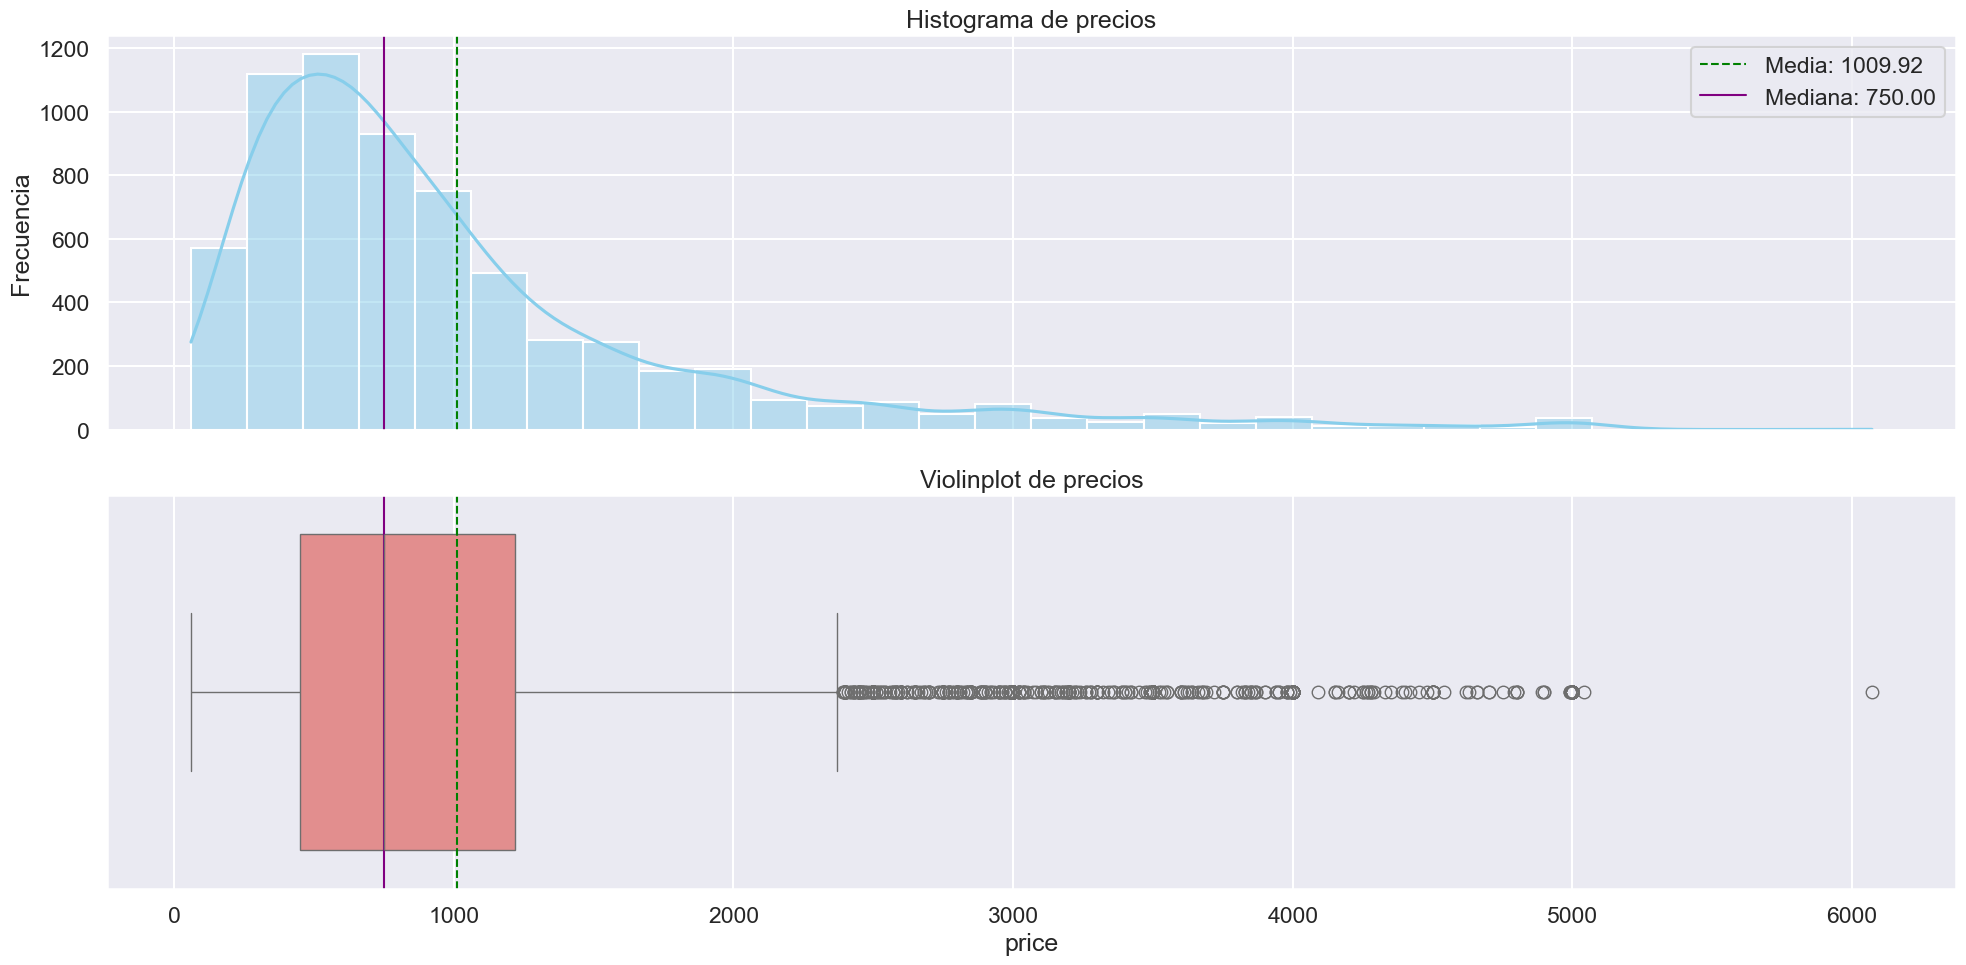

In [22]:
media_precio = df['price'].mean()
mediana_precio = df['price'].median()

sns.set_theme(context='talk', style='darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

sns.histplot(df['price'].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(media_precio, color='green', linestyle='--', linewidth=1.5, label=f'Media: {media_precio:.2f}')
axes[0].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5, label=f'Mediana: {mediana_precio:.2f}')
axes[0].set_title('Histograma de precios')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

sns.boxplot(x=df['price'].dropna(), ax=axes[1], color='lightcoral')
axes[1].axvline(media_precio, color='green', linestyle='--', linewidth=1.5)
axes[1].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5)
axes[1].set_title('Violinplot de precios')

plt.tight_layout()
plt.show()

Insights:
* Vemos que la distribución es asimétrica, con una cola larga de outliers a la derecha y con la mayoría de los precios hacia la izquierda. 
* Los outliers son de precios altos, más allá de 3.000 € y hasta 6.000 €.
* La mediana (750 €) está por debajo de la media (1009,92 €), lo cual confirma el sesgo positivo.

#### Imputación
En este contexto, imputar por la media no sería lo ideal porque se vería muy influenciada por outliers.   
Por lo que optamos por imputar usando la mediana por ciudad, tipo de habitación y accomodates. Esto es simple pero efectivo.

In [23]:
# Imputar mediana por grupos especificos.
df['price'] = df.groupby(['city', 'room_type', 'accommodates'])['price'].transform(
    lambda x: x.fillna(x.median()))

In [25]:
print(f'Hay {df['price'].isnull().sum()} precios con valores nulos')

Hay 6 precios con valores nulos


In [26]:
# Imputar mediana por grupos más generales.
df['price'] = df.groupby(['city', 'room_type'])['price'].transform(
    lambda x: x.fillna(x.median()))

La primera ejecucion del código resulto en grupos que seguían teniedo valores nulos en 6 registros, por eso agregamos una segunda parte con un grupo más general para estos casos (sin tomar en cuenta los 'accommodates', solo ciudad y tipo de habitacion).

#### Comprobación rápida.

In [28]:
print(f'Hay {df['price'].isnull().sum()} precios con valores nulos')

Hay 0 precios con valores nulos
